#Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn

import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Loading and Preprocessing Dataset

In [ ]:
mnist = fetch_openml('mnist_784')
X, y = mnist.data.astype('float32'), mnist.target.astype(int)

X /= 255.0

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
flattened_df = X.to_numpy().flatten()

# Find the number of unique elements in the flattened array
num_unique_elements = pd.Series(flattened_df).nunique()
print("Number of unique elements in the DataFrame:",num_unique_elements )
type(y[23245])

Number of unique elements in the DataFrame: 256


numpy.int64

In [ ]:
X.dtypes

pixel1      float64
pixel2      float64
pixel3      float64
pixel4      float64
pixel5      float64
             ...   
pixel780    float64
pixel781    float64
pixel782    float64
pixel783    float64
pixel784    float64
Length: 784, dtype: object

In [ ]:

n_samples = 60000

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size = n_samples, test_size=10000, random_state=42, stratify=y
)

In [ ]:
X_train.shape

(60000, 784)

#MLP Class and Train Function

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def train_mlp(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        if epoch %10 == 0:
            print("Epoch [{}/{}], Loss: {:}".format(epoch , num_epochs, loss.item()))

#Training and Predicting using MLP

In [ ]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=100)

# Initialize the MLP model, criterion, and optimizer
mlp_model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters())

# Train the MLP model
train_mlp(mlp_model, train_loader, criterion, optimizer)

Epoch [0/100], Loss: 0.26634758710861206
Epoch [10/100], Loss: 0.12750256061553955
Epoch [20/100], Loss: 0.08979610353708267
Epoch [30/100], Loss: 0.05151248350739479
Epoch [40/100], Loss: 0.03755555301904678
Epoch [50/100], Loss: 0.025884725153446198
Epoch [60/100], Loss: 0.02393890917301178
Epoch [70/100], Loss: 0.010613086633384228
Epoch [80/100], Loss: 0.012584934011101723
Epoch [90/100], Loss: 0.0014732874697074294


In [ ]:
mlp_model.eval()
with torch.no_grad():
    outputs = mlp_model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    f1_mlp = f1_score(y_test, predicted, average='weighted')
    cm_mlp = confusion_matrix(y_test, predicted)

print("MLP F1-score:", f1_mlp)


MLP F1-score: 0.957167208901151


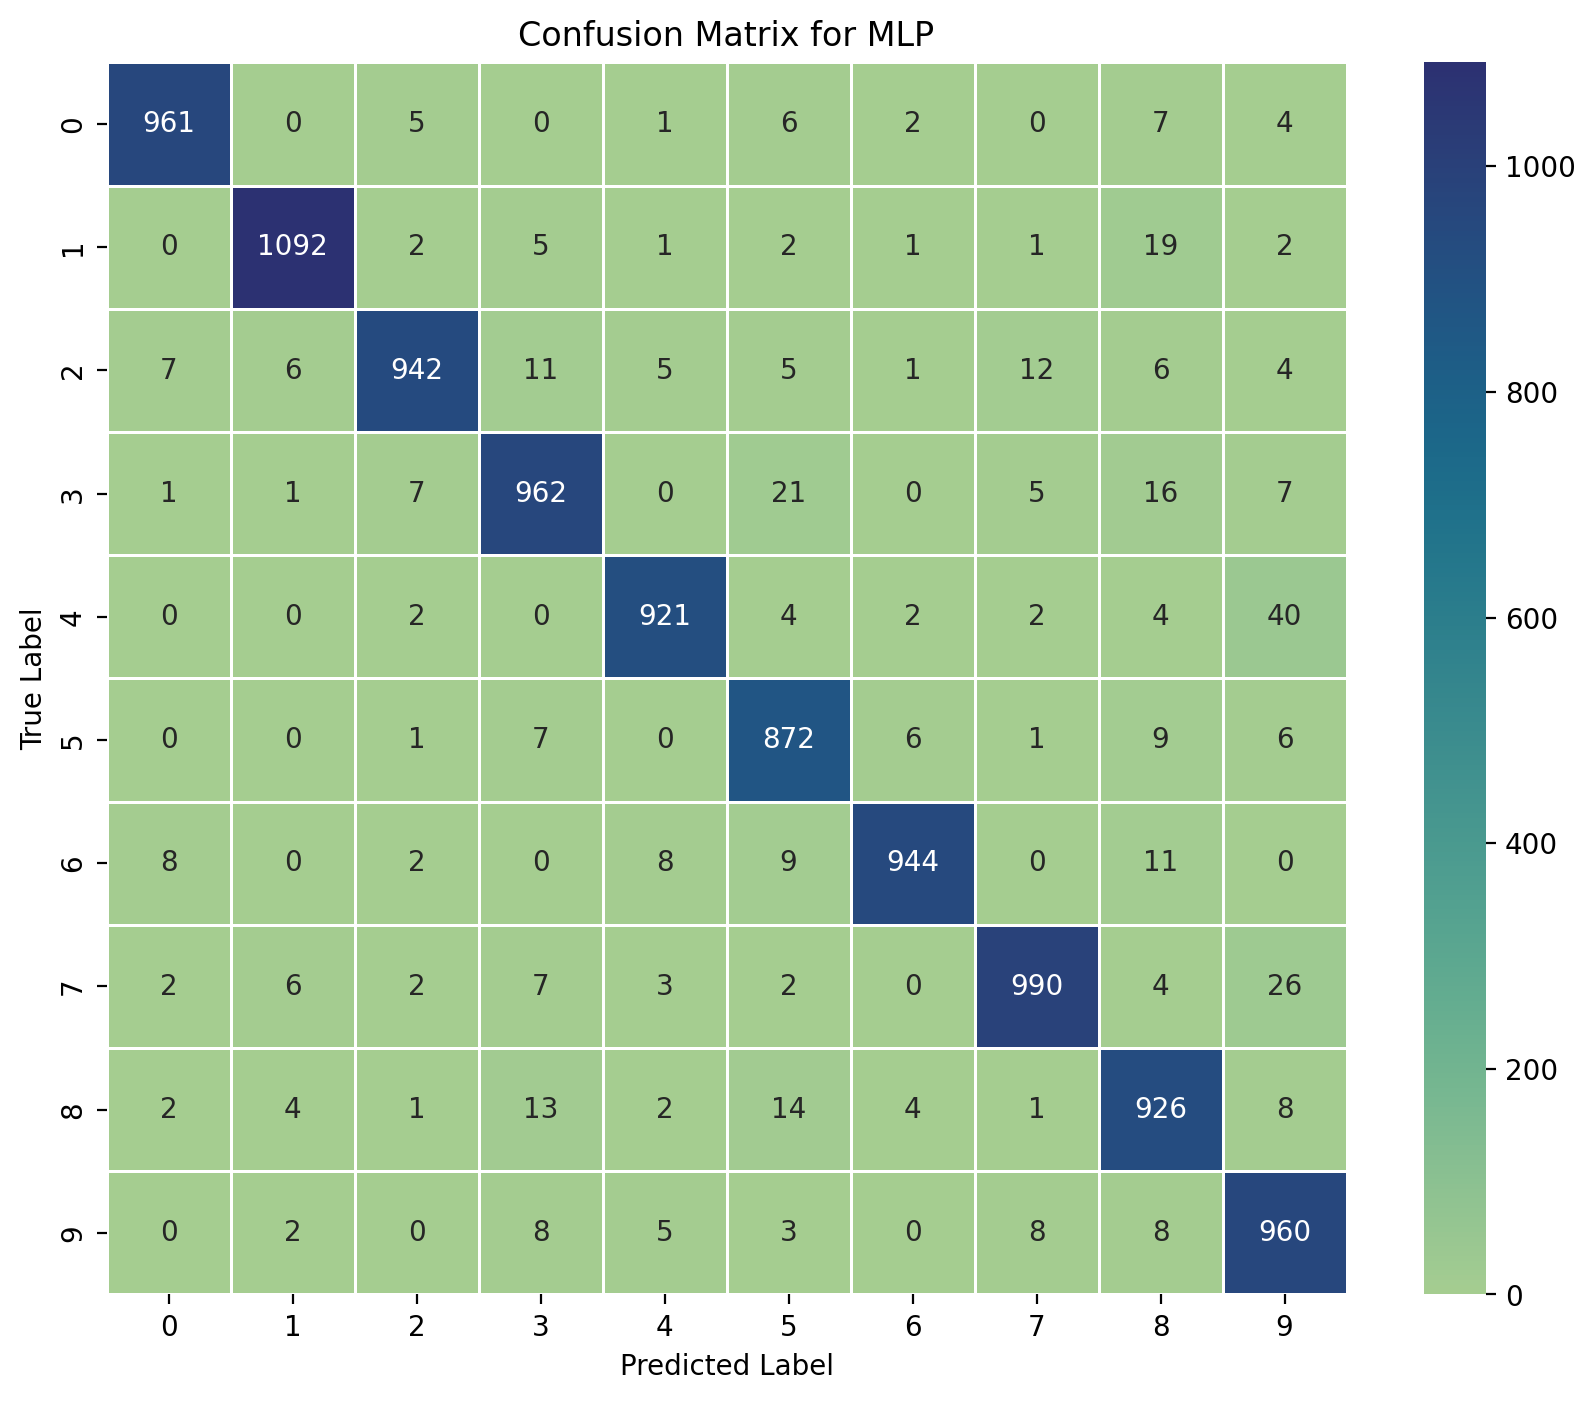

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='crest', linewidth=.5)
plt.title('Confusion Matrix for MLP')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#Training and Predicting using Random Forest Classifier

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("F1-score for Random Forest Classifier:", f1_rf)

F1-score for Random Forest Classifier: 0.9684833671332355


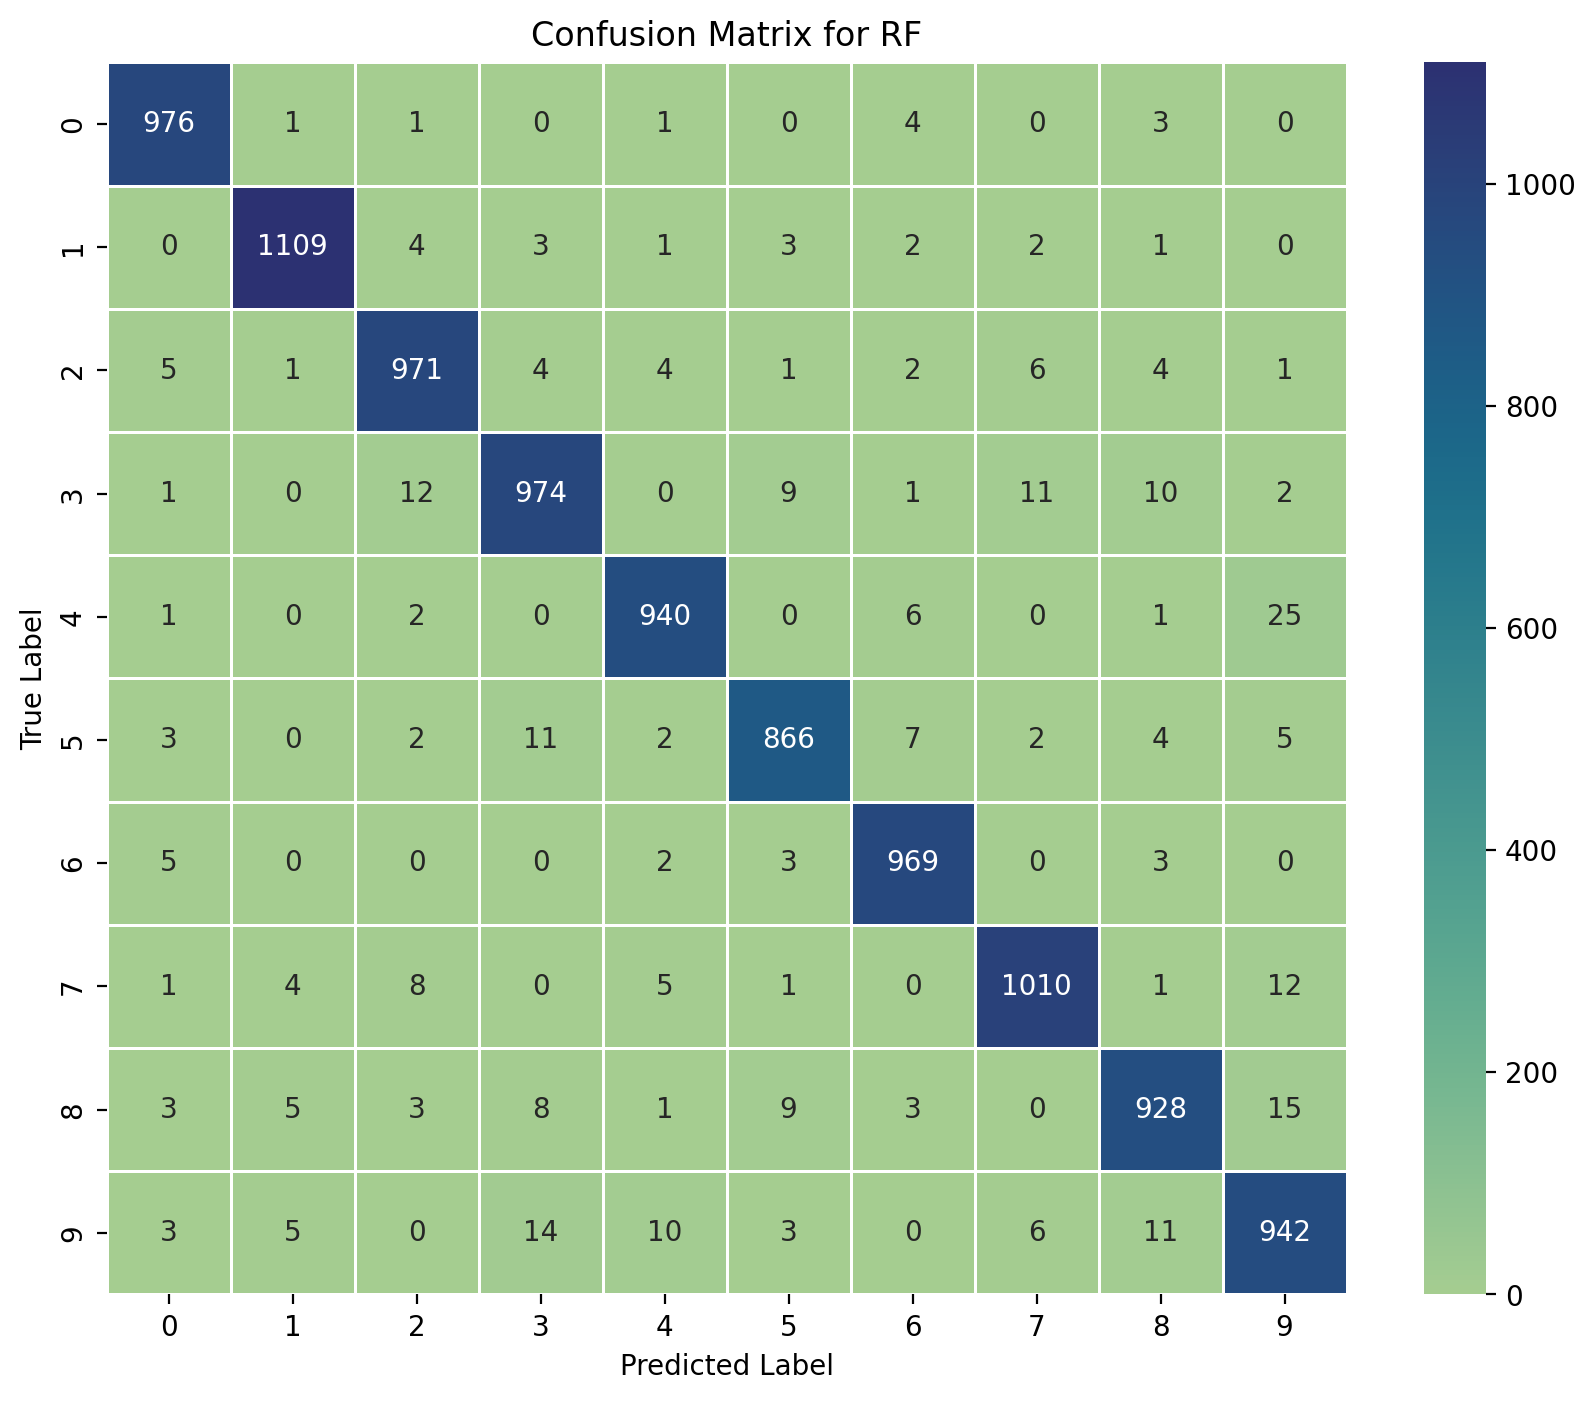

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='crest', linewidth=.5)
plt.title('Confusion Matrix for RF')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#Training and Predicting using Logistic Regression

In [ ]:
lr_model = LogisticRegression(max_iter=100, random_state=42, multi_class='multinomial')
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
cm_lr = confusion_matrix(y_test, y_pred_lr)

print("F1-score using Logistic Regression:", f1_lr, "\n")

F1-score using Logistic Regression: 0.9215694794462166 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


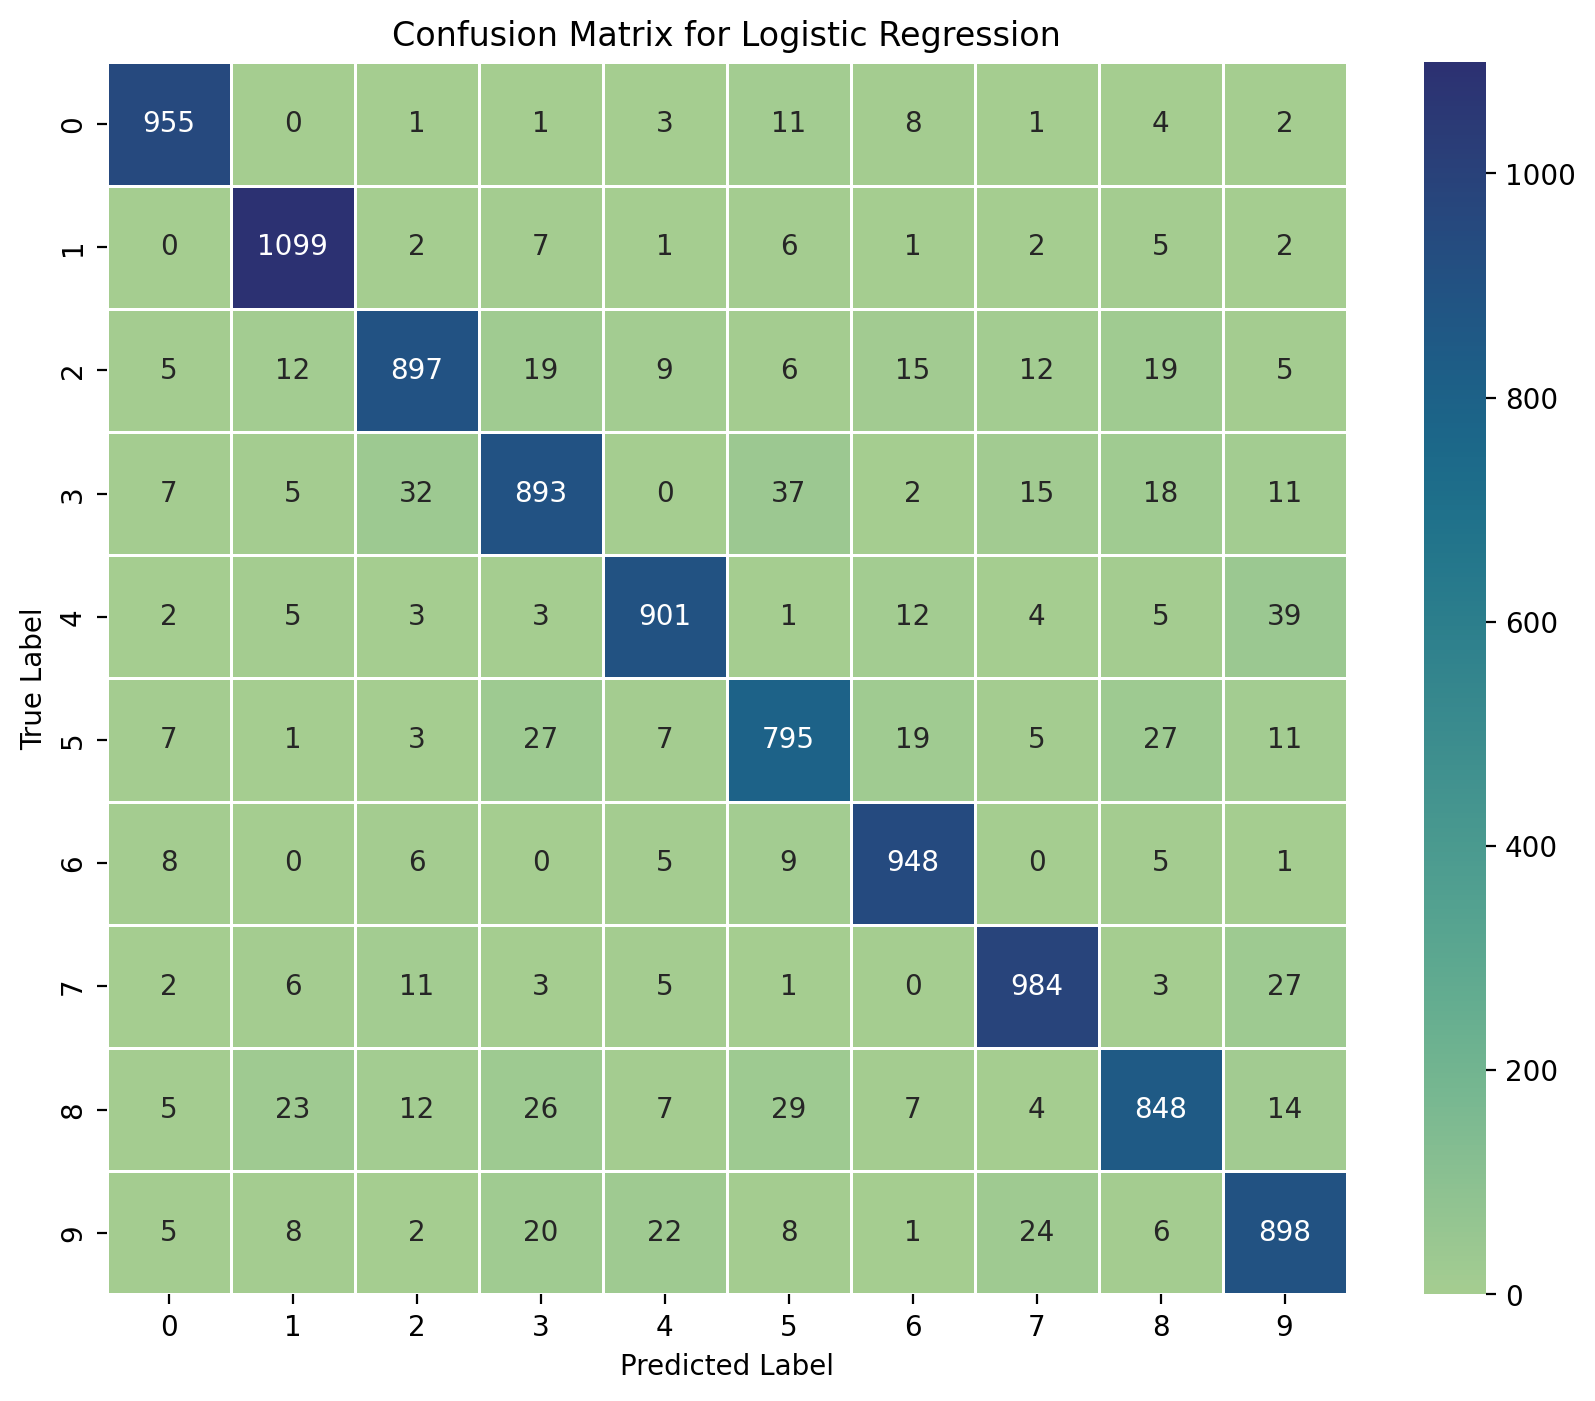

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='crest', linewidth=.5)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
X_test_tensor.shape

torch.Size([10000, 784])

# Comparision of the Models and Commonly Confused Digits

## F1 Score for the models-

MLP Classifier: 0.9572

Random Forest: 0.9685

Logistic Regression: 0.9216

Hence, Random Forest is as good classifier as the MLP classifier. Logistic Regression is not able to classify as good as the other two models, but still gives good F1 score.


## Commonly Confused Digits

Based on the provided confusion matrices, the digits that are most commonly confused with each other are:

**Digit 5 and Digit 3**: There are a lot of instances where the digit 5 was mistaken for digit 3. This confusion can occur due to the similar shape and structure of these digits when handwritten, especially if the loop of the 5 is not fully closed or if the 3 has a tighter curvature.

**Digit 9 and Digit 4**: There are a lot of instances where the digit 9 was mistaken for digit 4. In fact, this pair is the most mis-classified pair of numbers across all models. This can happen because both digits share a vertical line component, and in some handwriting styles, the top part of 9 might resemble the top part of 4.

**Digit 7 and Digit 9**: There are a lot of instances where the digit 7 was mistaken for digit 9. This pair is the second-most mis-classified pair. The confusion might arise from handwriting styles where the horizontal line of 7 is short, making it look similar to the top part of 9.

Similary, digit 5 and digit 8 & digit 3 and digit 8 are also mis-classified a lot because of their similar structure/shape.

These confusions primarily occur due to the variability in handwriting styles, where certain features of one digit might closely resemble those of another, leading to classification errors.

#Ploting t-SNE for Trained and Untrained Models

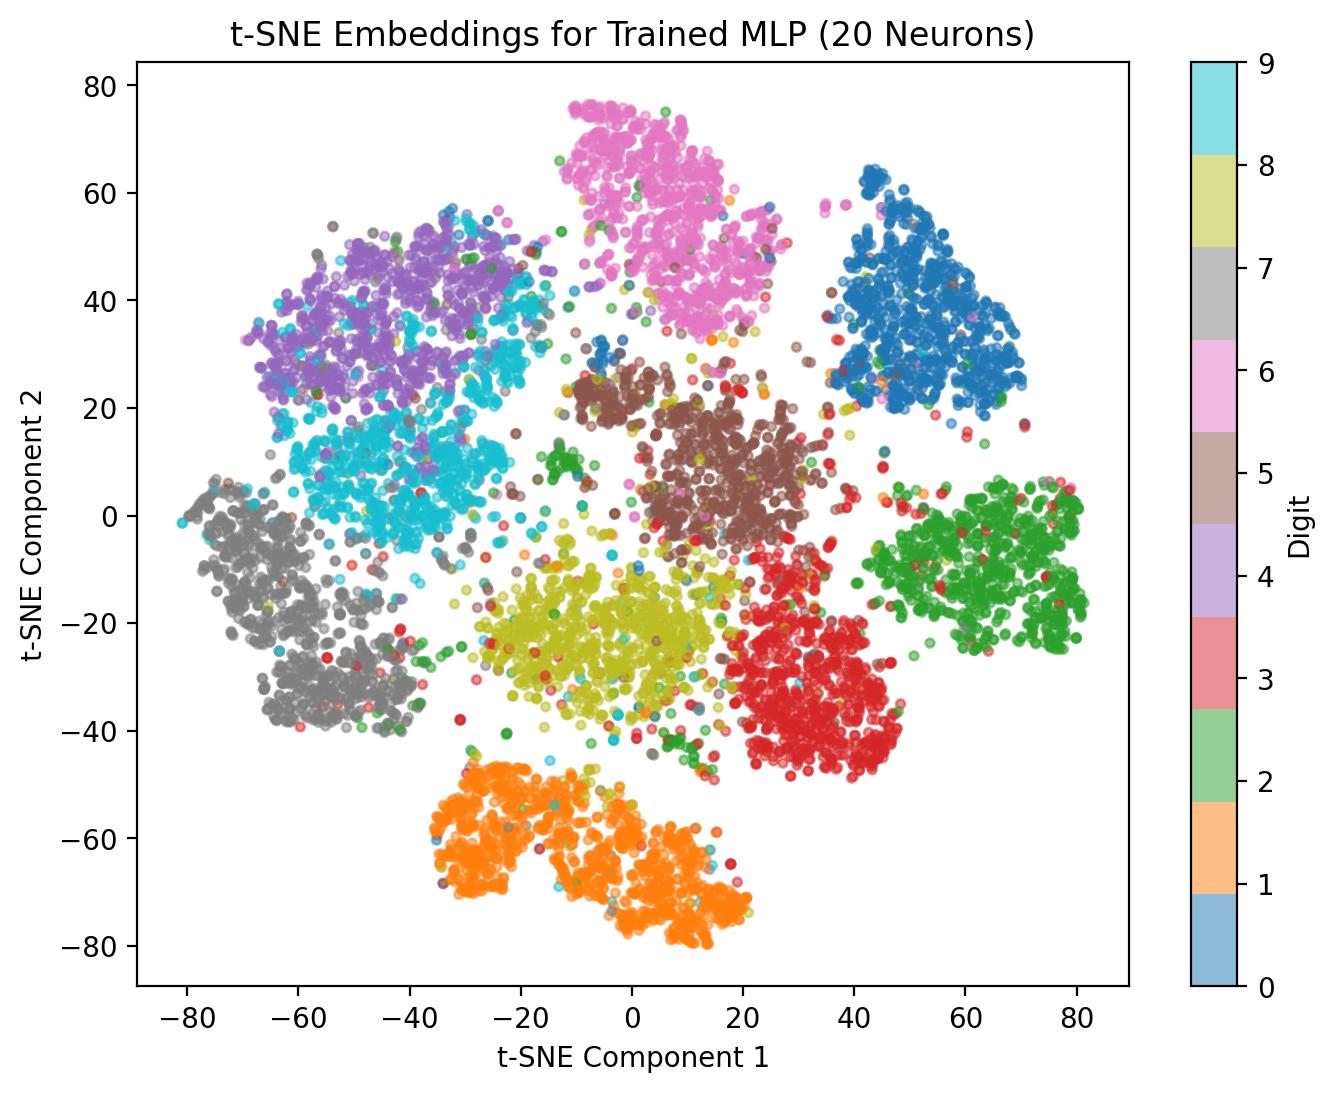

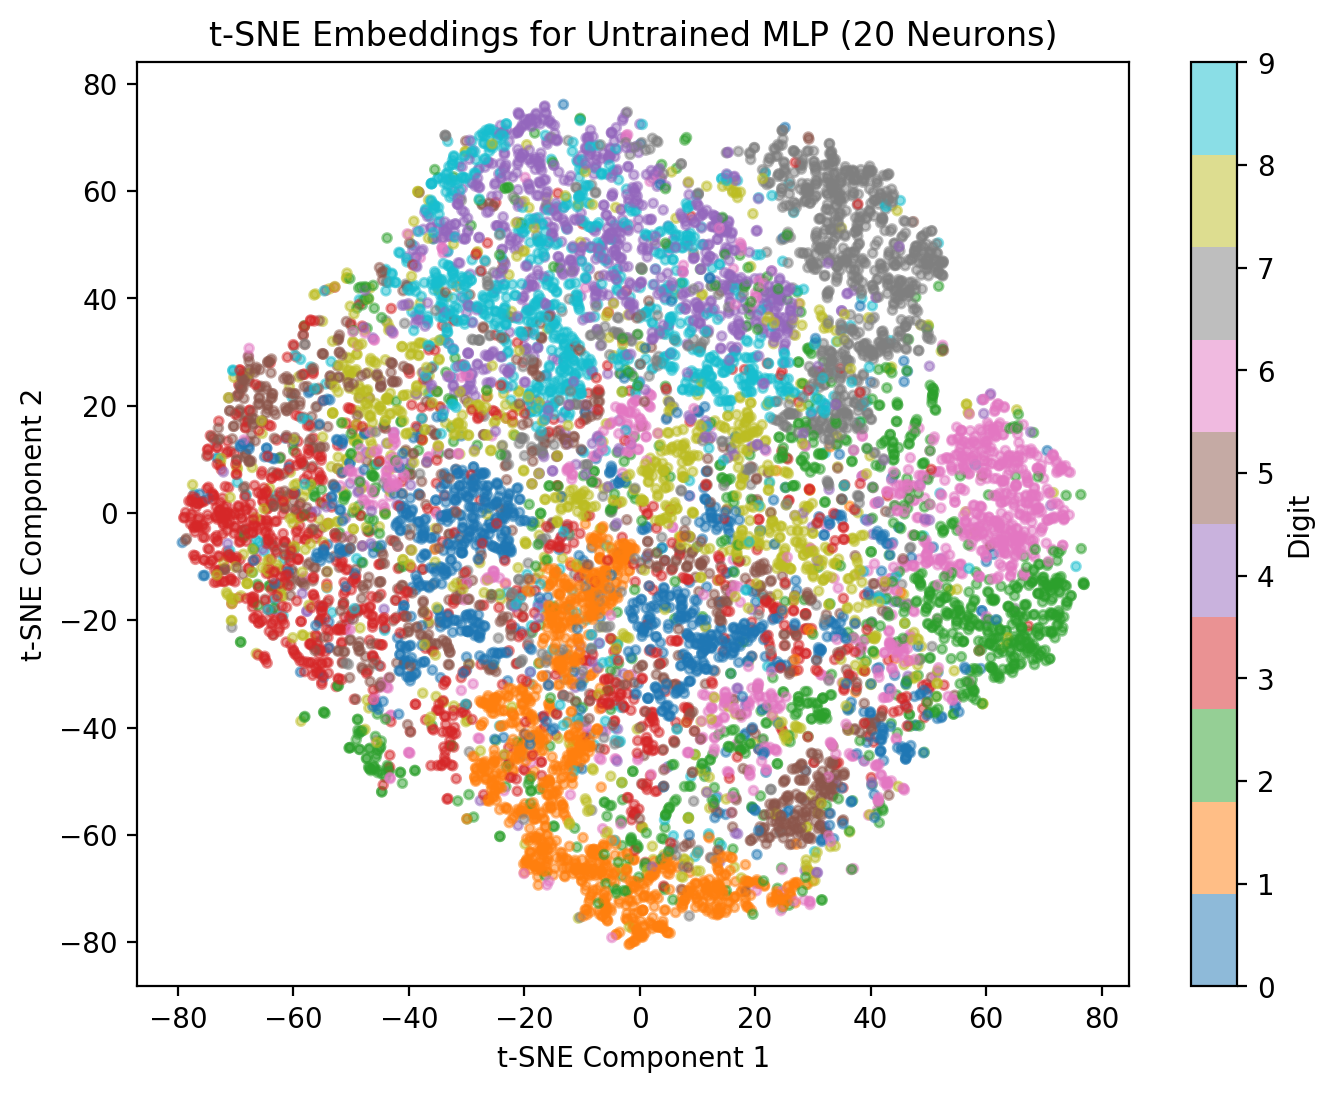

In [ ]:
def extract_layer_output(model, layer_index, inputs):
    layer_output = None
    for idx, module in enumerate(model.children()):
        if idx == layer_index:
            layer_output = module(inputs)
            break
    return layer_output

# Function to apply t-SNE and plot the embeddings
def plot_tsne(model, layer_index, inputs, targets, title):
    layer_out = extract_layer_output(model, layer_index-1, inputs)
    layer_output = extract_layer_output(model, layer_index, layer_out)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        layer_output = layer_output.cuda()

    layer_output_flatten = layer_output.view(layer_output.size(0), -1)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_output = tsne.fit_transform(layer_output_flatten.cpu().detach().numpy())

    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_output[:, 0], tsne_output[:, 1], c=targets, cmap='tab10', alpha=0.5, s=10)
    plt.title(title)
    plt.colorbar(label='Digit')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

# Plot t-SNE for trained MLP
plot_tsne(mlp_model, 1, X_test_tensor, y_test_tensor, title='t-SNE Embeddings for Trained MLP (20 Neurons)')

# Create an untrained MLP
untrained_mlp_model = MLP()

# Plot t-SNE for untrained MLP
plot_tsne(untrained_mlp_model, 1, X_test_tensor, y_test_tensor, title='t-SNE Embeddings for Untrained MLP (20 Neurons)')


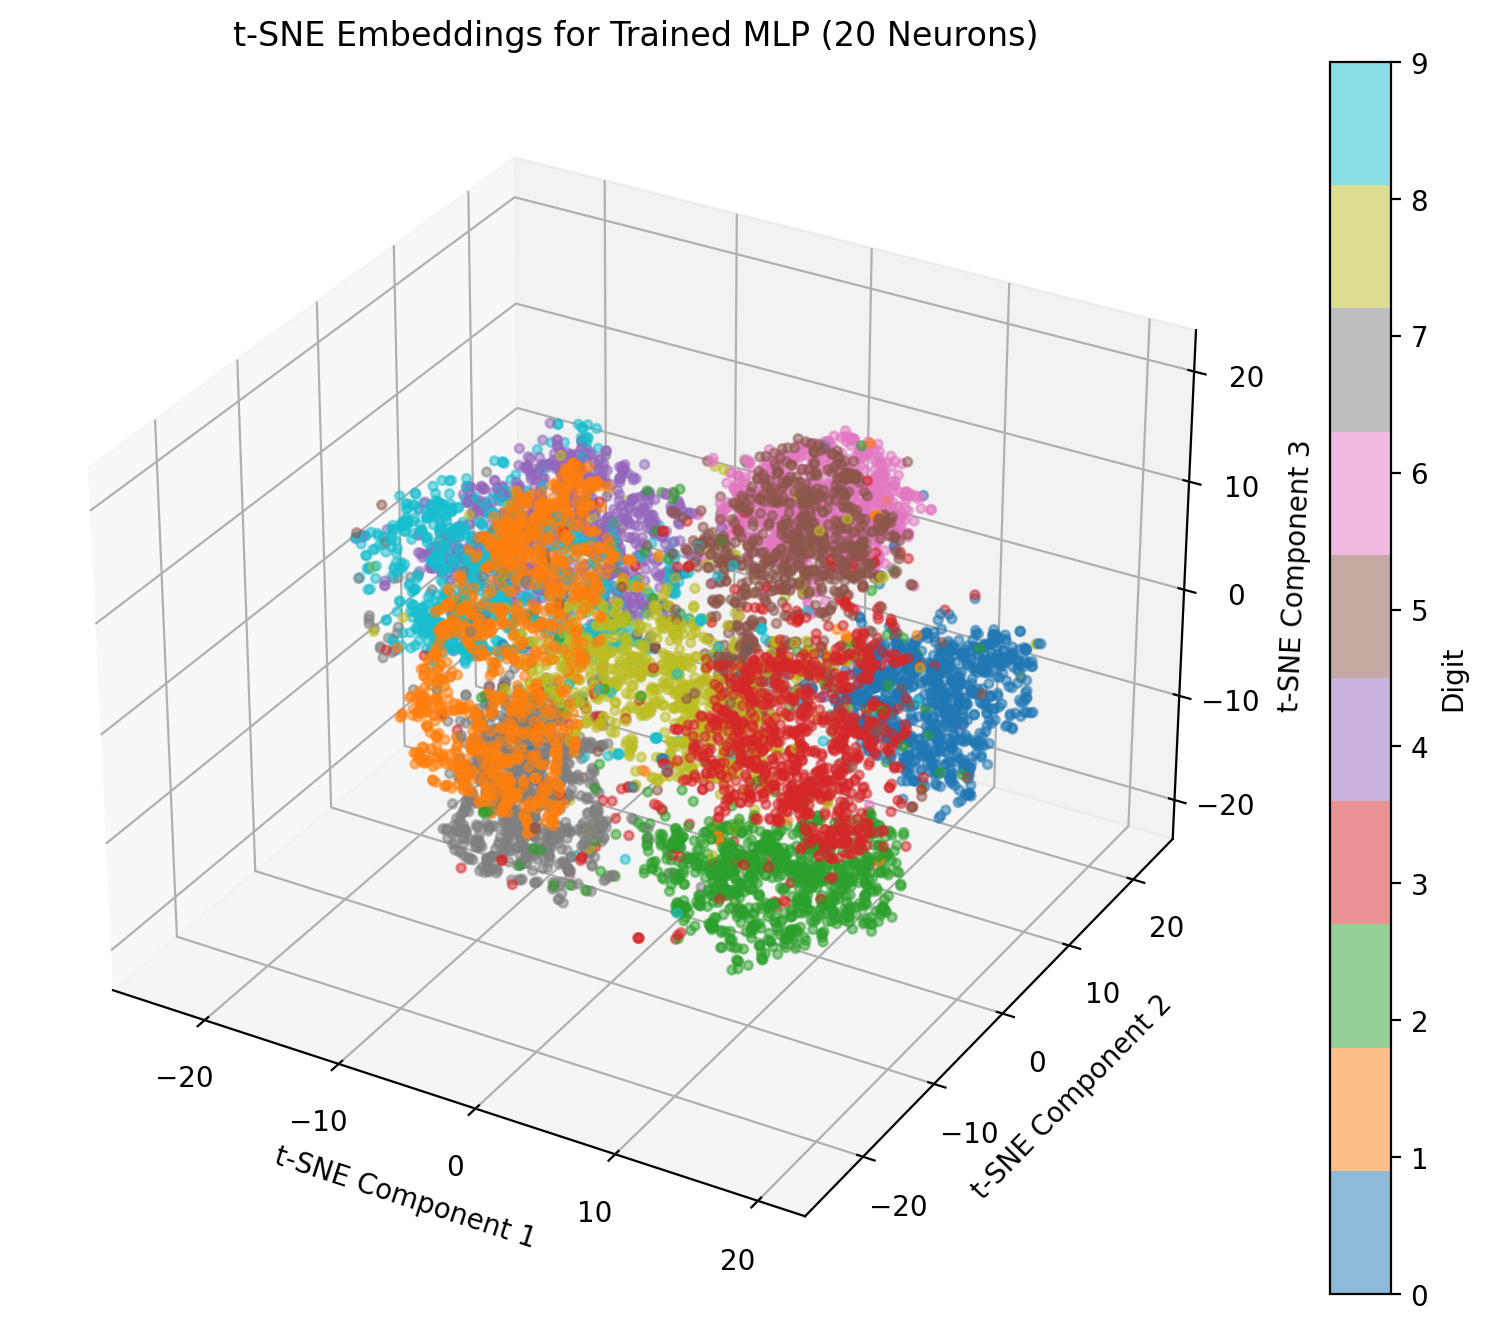

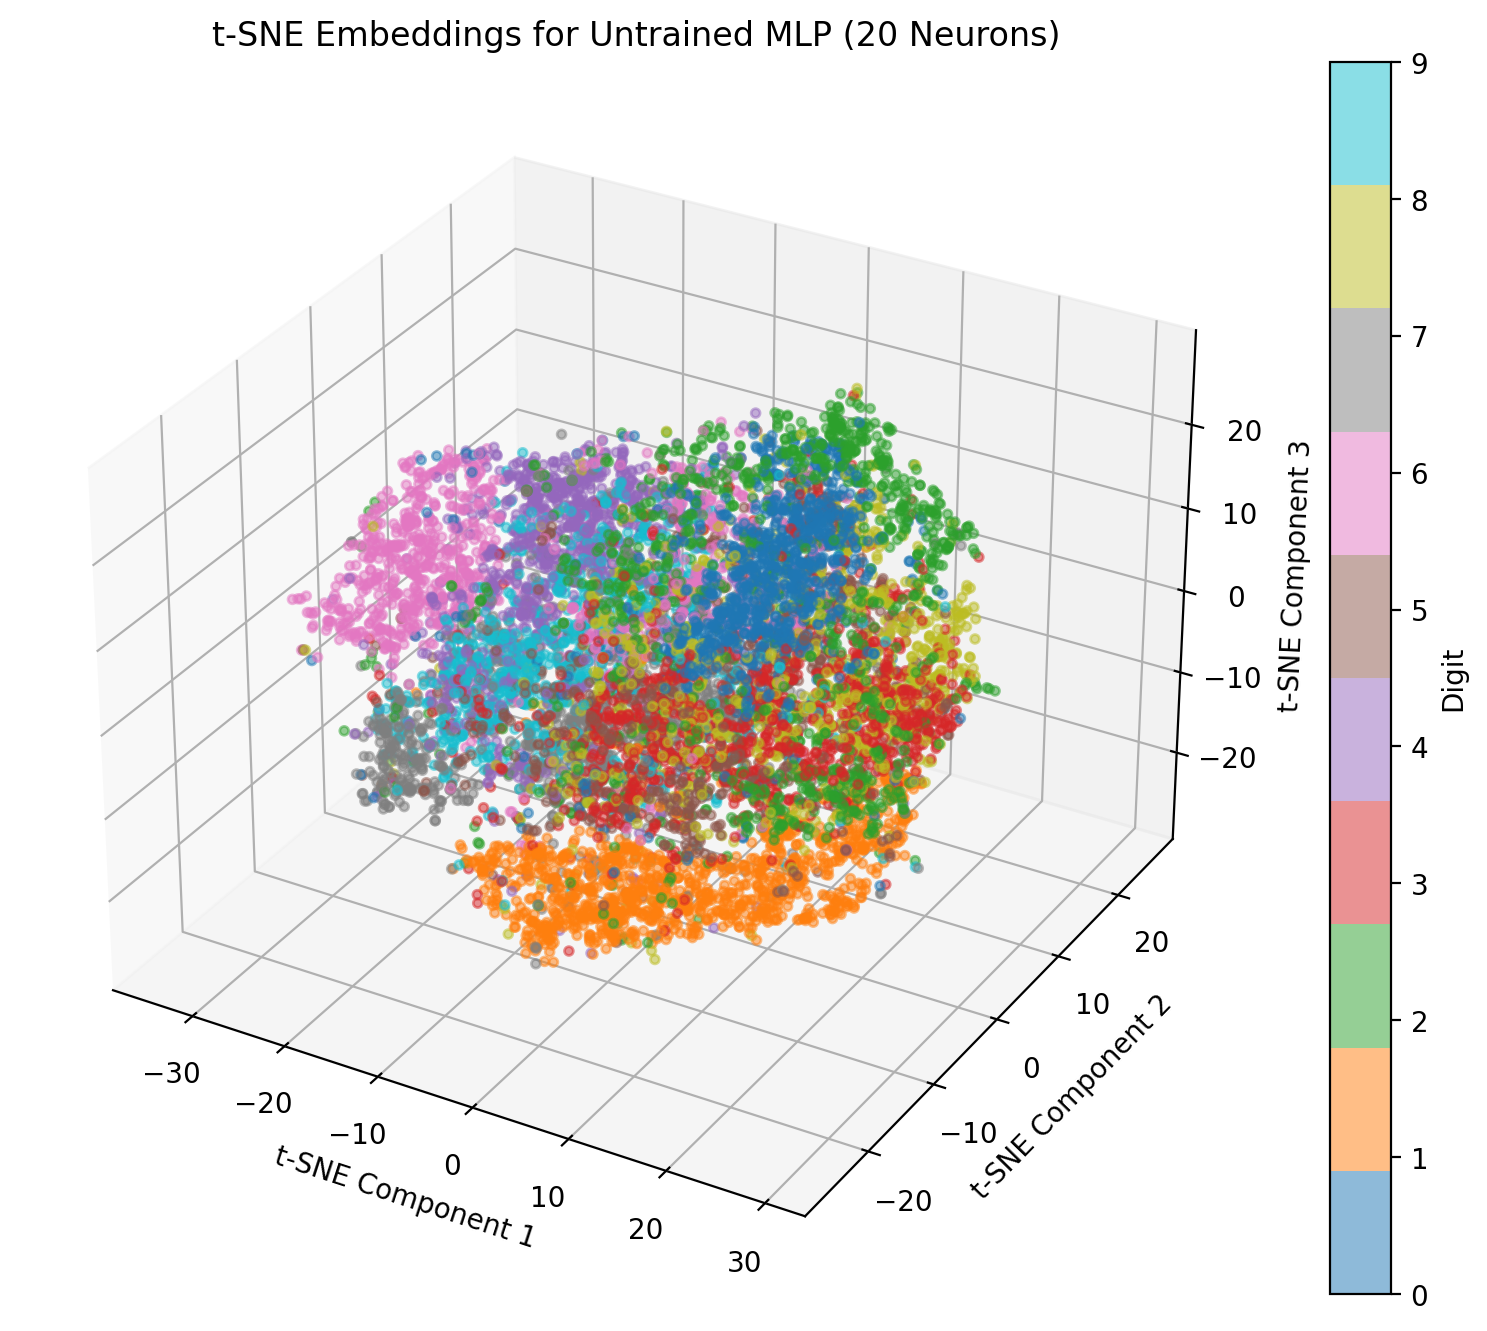

In [ ]:
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def extract_layer_output(model, layer_index, inputs):
    layer_output = None
    for idx, module in enumerate(model.children()):
        if idx == layer_index:
            layer_output = module(inputs)
            break
    return layer_output

# Function to apply t-SNE and plot the embeddings
def plot_tsne(model, layer_index, inputs, targets, title):
    layer_out = extract_layer_output(model, layer_index-1, inputs)
    layer_output = extract_layer_output(model, layer_index, layer_out)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        layer_output = layer_output.cuda()

    layer_output_flatten = layer_output.view(layer_output.size(0), -1)

    # Apply t-SNE with 3 components
    tsne = TSNE(n_components=3, random_state=42)
    tsne_output = tsne.fit_transform(layer_output_flatten.cpu().detach().numpy())

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(tsne_output[:, 0], tsne_output[:, 1], tsne_output[:, 2], c=targets, cmap='tab10', alpha=0.5, s=10)
    ax.set_title(title)
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')
    plt.colorbar(scatter, label='Digit')
    plt.show()

# Plot t-SNE for trained MLP
plot_tsne(mlp_model, 1, X_test_tensor, y_test_tensor, title='t-SNE Embeddings for Trained MLP (20 Neurons)')

# Create an untrained MLP
untrained_mlp_model = MLP()

# Plot t-SNE for untrained MLP
plot_tsne(untrained_mlp_model, 1, X_test_tensor, y_test_tensor, title='t-SNE Embeddings for Untrained MLP (20 Neurons)')


# Conclusion
As the classes in the MNIST dataset got well-separated in the t-SNE visualizations for the activations of the second layer in our Multi-Layer Perceptron (MLP) model, several conclusions can be drawn:

**1.Effective Feature Learning** :
The clear separation of classes indicates that the MLP has learned effective features for distinguishing between the different digits. The second layer, with 20 neurons, is capable of capturing complex patterns and relationships in the data that allow for this differentiation. This is a sign of a well-trained model that has learned meaningful representations of the input data.

**2.Impact of Training** :
Comparing the t-SNE plots of the trained versus the untrained model highlights the importance of training. The trained model's ability to separate the classes suggests that the learning process has successfully optimized the model's weights to capture the variance and structure within the dataset. In contrast, an untrained model's activations would likely show no clear separation between classes, reflecting the random initialization of weights.

**3.Model Evaluation** :
The visualization can serve as a tool for model evaluation and debugging. If certain digits or classes were not as well separated as others, it might indicate areas where the model struggles to differentiate between similar digits. For example, here classes 4 and 9 are intermixed which can be seen in the t-SNE plot.


#Predicting on Fashion MNIST Dataset

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)

def extract_layer_output(model, layer_index, inputs):
    layer_output = None
    for idx, module in enumerate(model.children()):
        if idx == layer_index:
            layer_output = module(inputs)
            break
    return layer_output

# Function to apply t-SNE and plot the embeddings
def plot_tsne(model, layer_index, inputs, targets, title):
    layer_out = extract_layer_output(model, layer_index-1, inputs)
    layer_output = extract_layer_output(model, layer_index, layer_out)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        layer_output = layer_output.cuda()

    layer_output_flatten = layer_output.view(layer_output.size(0), -1)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_output = tsne.fit_transform(layer_output_flatten.cpu().detach().numpy())

    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_output[:, 0], tsne_output[:, 1], c=targets, cmap='tab10', alpha=0.5, s=10)
    plt.title(title)
    plt.colorbar(label='Class')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()


# Set model to evaluation mode
mlp_model.eval()


predicted_labels = []
true_labels = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.view(inputs.size(0), -1)  # Flatten the input images
        outputs = mlp_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(targets.tolist())
        f1_mlp_fashion_mnist = f1_score(targets, predicted, average='weighted')
        cm_mlp_fashion_mnist = confusion_matrix(targets, predicted)
        break  # Only one batch is needed

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy on Fashion-MNIST:", accuracy)
print("F1-score on Fashion-MNIST:", f1_mlp_fashion_mnist)



Accuracy on Fashion-MNIST: 0.1466
F1-score on Fashion-MNIST: 0.08436673302615981


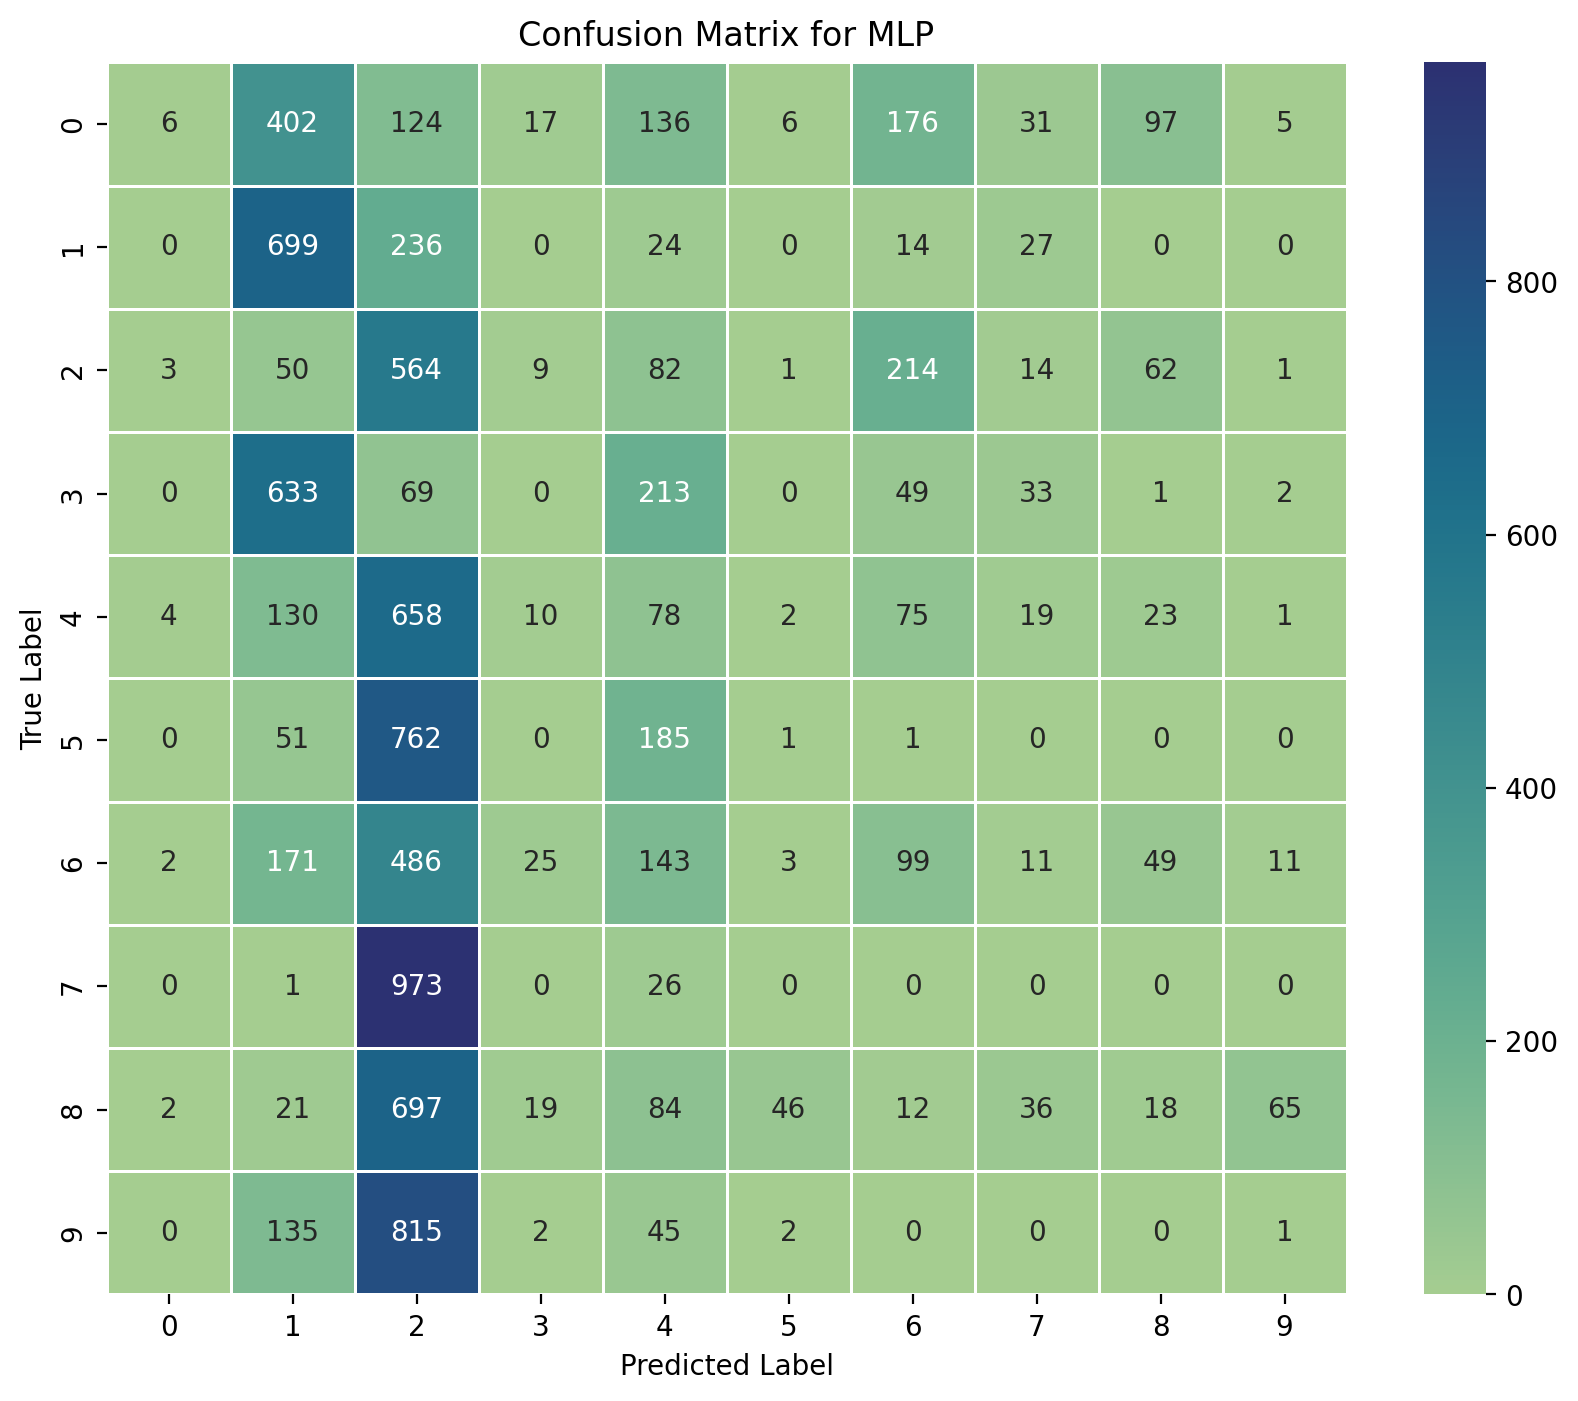

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_mlp_fashion_mnist, annot=True, fmt='d', cmap='crest', linewidth=.5)
plt.title('Confusion Matrix for MLP')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##Observations
Poor Performance: The model, trained on digits, performs poorly on fashion items. This poor performance is expected because the features learned from digits do not apply to clothing items. For example, the curve of a "6" does not help identify a shirt.

Misclassifications: The model makes confident predictions on Fashion-MNIST images, but these predictions are largely incorrect. This misclassification happens because the model tries to match the learned digit features with clothing items, leading to high confidence in irrelevant predictions.

Insight on Generalization: The experiment underscores that a model performing well on one dataset may not generalize to another, especially when the new dataset is from a different domain. This is a practical demonstration of the saying, "If it works on MNIST, it may still fail on others."

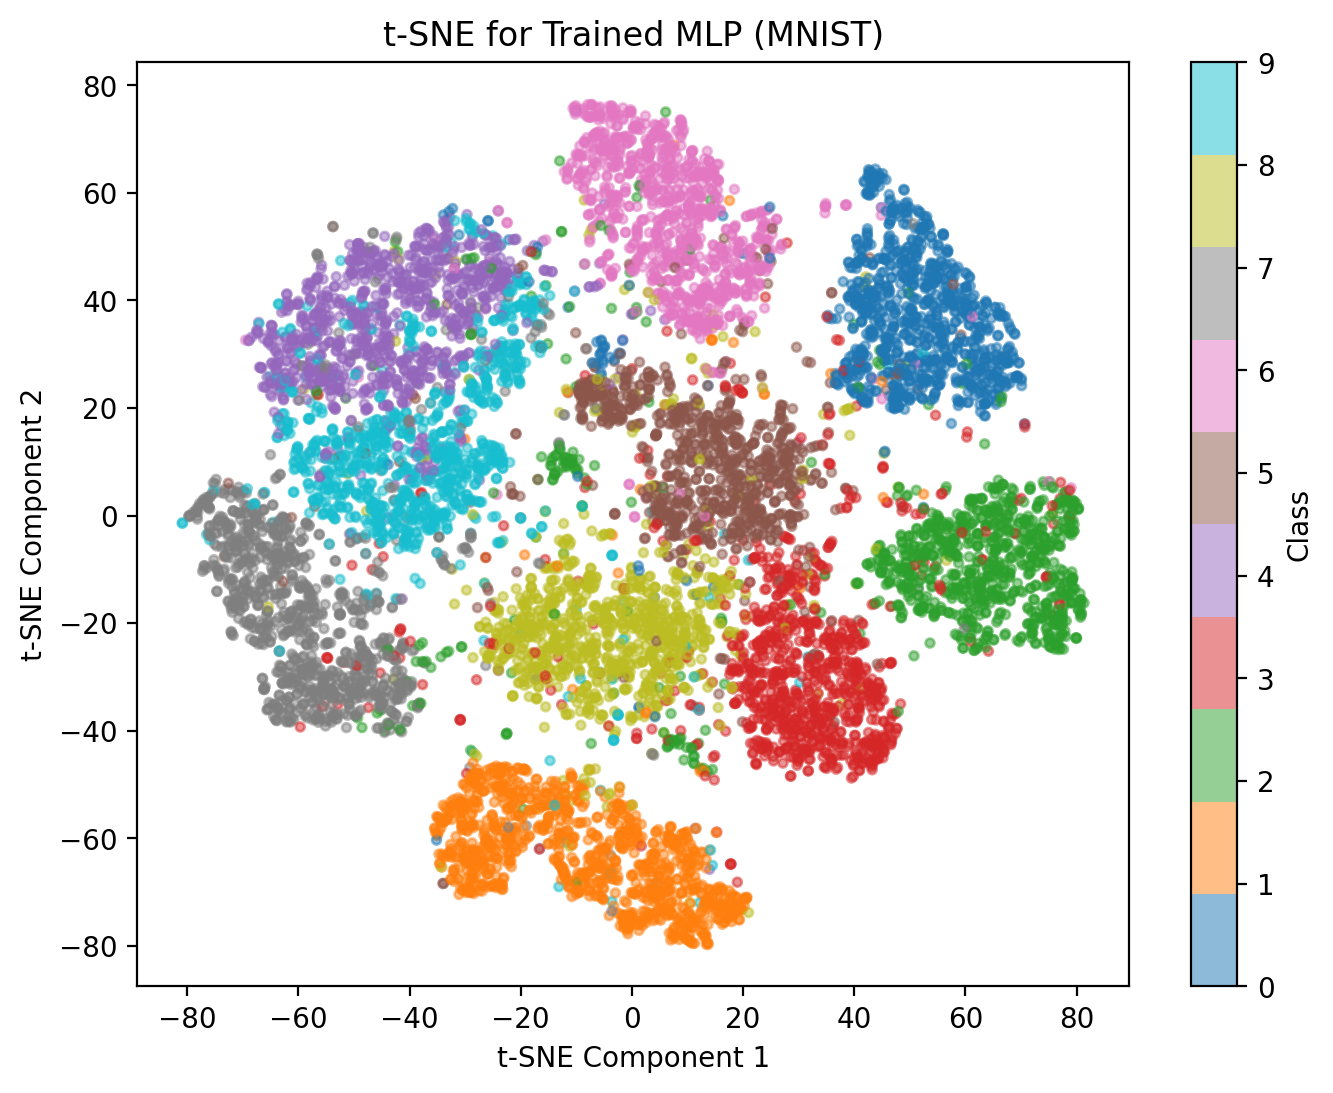

In [ ]:
# Plot t-SNE for MNIST
plot_tsne(mlp_model, 1, X_test_tensor, y_test_tensor, title='t-SNE for Trained MLP (MNIST)')

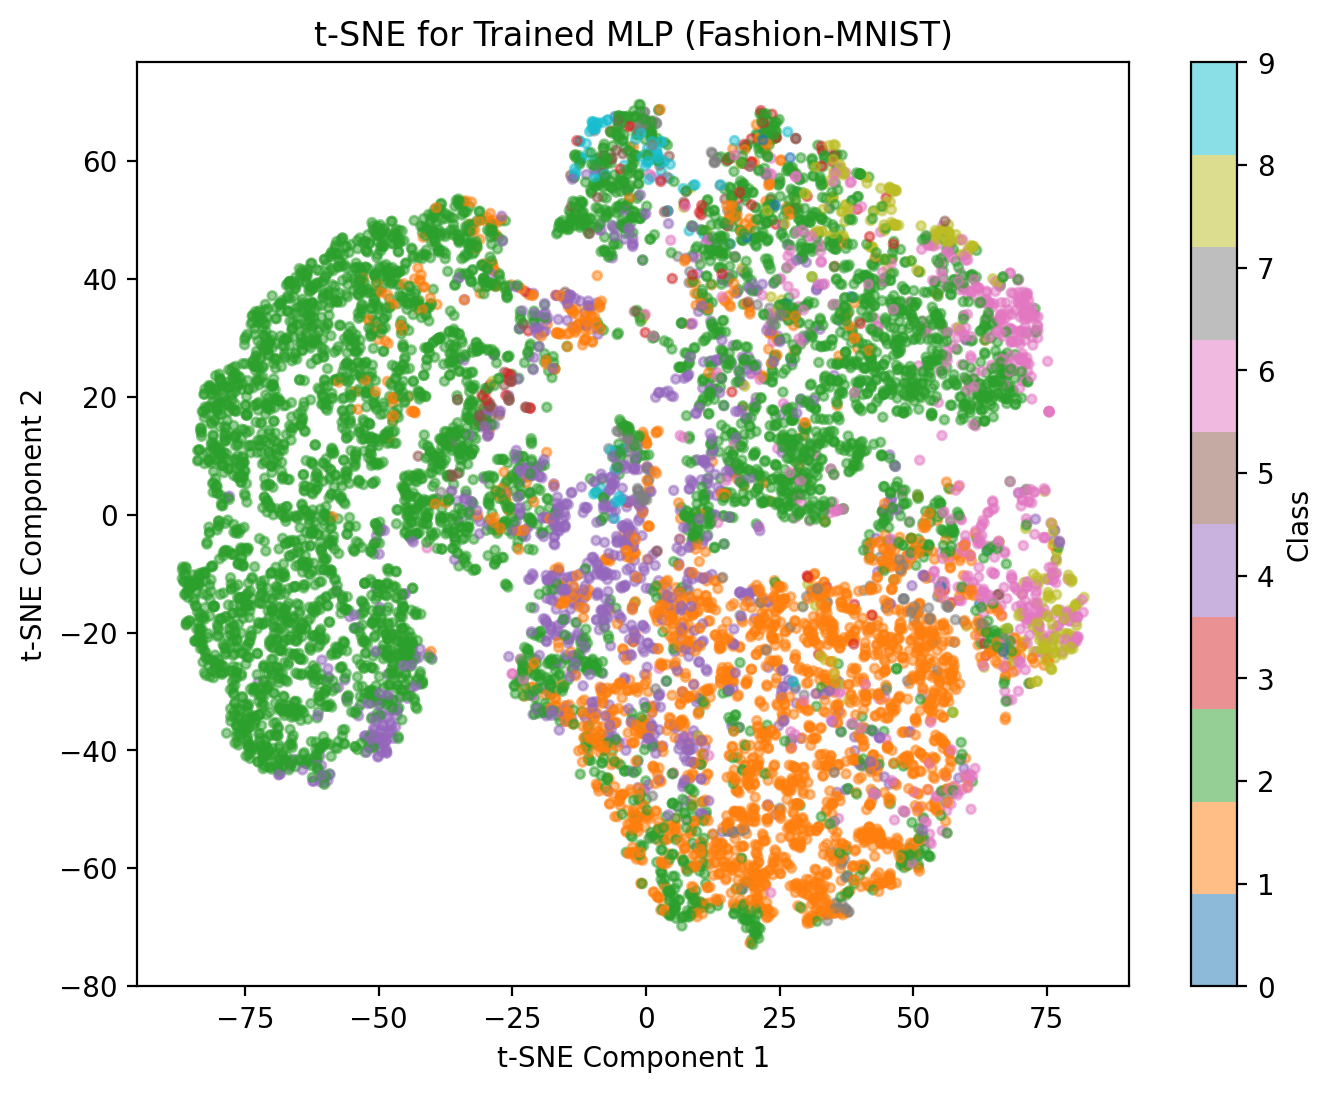

In [ ]:
# Plot t-SNE for Fashion-MNIST
plot_tsne(mlp_model, 1, inputs, predicted, title='t-SNE for Trained MLP (Fashion-MNIST)')

#Observations
Generalization Limitations: The model's embeddings for Fashion-MNIST do not show class separation, highlighting the challenges in applying a model trained on one domain (handwritten digits) to another (fashion items).

Model Adaptability: This experiment underscores the importance of dataset specificity in model training and the potential need for transfer learning or model re-training when dealing with new, substantially different data distributions.